### table of contents
- About datasets
- Feature engineering
- Missing value handling
- outlier handling
- Correlation for each feature point
- Data visualization
- fill in those with 0 windspeed with predictions
- Prediction with linear model
- Prediction in ensemble learning (RandomForest, LightGBM)
-submissions

Reference notebook:
https://www.kaggle.com/code/viveksrinivasan/eda-ensemble-model-top-10-percentile

### About datasets
##### Feature point
- datetime : year date time
- season : Season-1＝spring, 2=summer, 3=fall, 4=winter
- holiday : Whether the day is a holiday
- workingday : whether the day is not a weekend or a holiday
- weather : weather-1=clear/a little cloud, 2=cloudy/hazy, 3=a little snow/light rain/thunderstorm, 4=heavy rain/freezing rain/thunderstorm/snow+fog
- temp : Temperature
- atemp : Feeling temperature
- humidity : relative humidity
- windspeed : wind speed
- casual : Number of rentals by new registrants
- registered : Number of rentals of existing registrants
- count : total number of rentals

In [26]:
# Library's input
import pylab
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from datetime import datetime
import calendar
from scipy import stats
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [27]:
# data set
train_df = pd.read_csv('Data/train.csv')

In [28]:
# Data set's great output power
print(train_df.shape)

(10886, 12)


In [29]:
# best performance output
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [30]:
train_df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [31]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


### Specialized Engineering

- Season, holiday, workingday, and weather are int type, but category type is more suitable, so change it.
- Create date, year, month, hour, weekDay from datetime
- Removed datetime as it is no longer needed

In [32]:
# create a new column from datetime
# change season and weather values
train_df["date"] = train_df.datetime.apply(lambda x : x.split()[0])
train_df["year"] = train_df.datetime.apply(lambda x : x.split()[0].split("-")[0])
train_df["hour"] = train_df.datetime.apply(lambda x : x.split()[1].split(":")[0])
train_df["weekday"] = train_df.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
train_df["month"] = train_df.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
train_df["season"] = train_df.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
train_df["weather"] = train_df.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })
# output for confirmation
train_df.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,hour,weekday,month
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,00,Saturday,January


In [33]:
# change to category type
categoryVariableList = ["season", "holiday", "workingday", "weather", "year", "hour", "month", "weekday"]
for var in categoryVariableList:
    train_df[var] = train_df[var].astype("category")
# Confirm changes
print(train_df.dtypes)

datetime        object
season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
date            object
year          category
hour          category
weekday       category
month         category
dtype: object


In [34]:
# remove datetime
train_df = train_df.drop(["datetime"], axis=1)
train_df.head(1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,hour,weekday,month
0,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,00,Saturday,January



### Missing value handling

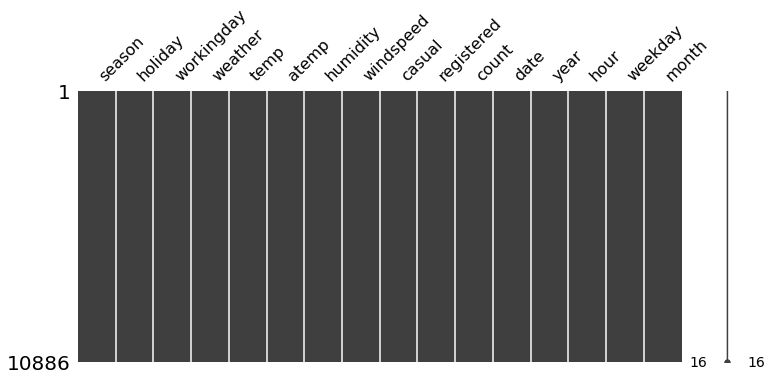

In [70]:
# Missing value visualization
msno.matrix(train_df, figsize=(12,5))
plt.savefig('foo.png', bbox_inches='tight')

### external reasons

Since the seemingly count variable contains outliers, display a boxplot to visualize the outliers

- From the boxplot of the count variable, you can see that the data is biased toward the larger side.
- From the seasonal boxplots, spring shows relatively low values ​​compared to other seasons.
- The hourly boxplot shows that the median is higher at 7-8am and 5-6pm. This is probably because many people use schools and offices.
- From the boxplot for each workingday, it can be seen that workingday has more outliers.
- The yearly boxplot shows higher values ​​in 2012 than in 2011.

[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Year')]

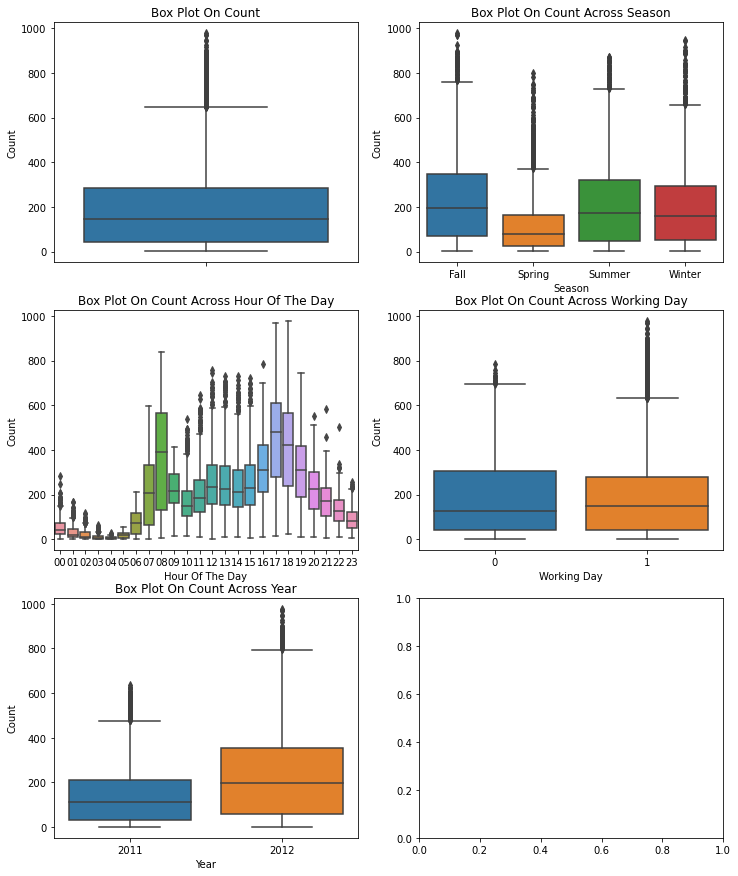

In [36]:
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(12, 15)
sns.boxplot(data=train_df,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train_df,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train_df,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train_df,y="count",x="workingday",orient="v",ax=axes[1][1])
sns.boxplot(data=train_df,y="count",x="year",orient="v",ax=axes[2][0])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[2][0].set(xlabel='Year', ylabel='Count',title="Box Plot On Count Across Year")

In [37]:
# Create a DataFrame without outliers
train_df_without_outliers = train_df[np.abs(train_df["count"]-train_df["count"].mean())<=(3*train_df["count"].std())] 

In [38]:
print ("Shape Of The Before Ouliers: ",train_df.shape)
print ("Shape Of The After Ouliers: ",train_df_without_outliers.shape)

Shape Of The Before Ouliers:  (10886, 16)
Shape Of The After Ouliers:  (10739, 16)



### View correlation for each feature point

Check the correlation between count and other feature points by creating a correlation matrix for each feature point

- We found that temp and atemp are highly correlated. One of them needs to be removed because it shows multiple empathy
- I thought that atemp had a high correlation with humidity and windspeed, but it turned out that there was almost no correlation. Therefore, I thought that humidity and windspeed were also necessary as explanatory variables.
- It can be seen that count and humidity have an inversely proportional relationship.
- count was found to be highly correlated with temp and atemp.
-Registered and casual are not considered because they are not used for prediction.
- From the scatterplot, windspeed has many values ​​of 0 and is separated from other values, so it is predicted that this is not an actual measured value.

<AxesSubplot:>

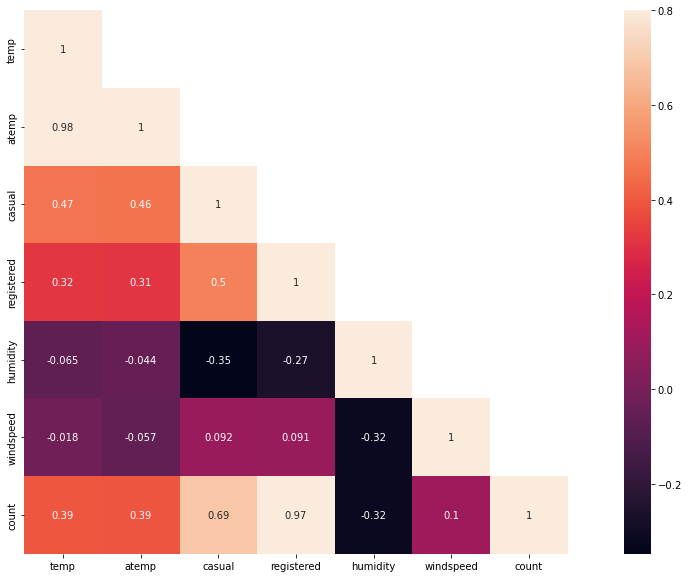

In [39]:
# Visualize how much correlation there is for each feature point with a heat map
corrMatt = train_df[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

<AxesSubplot:xlabel='humidity', ylabel='count'>

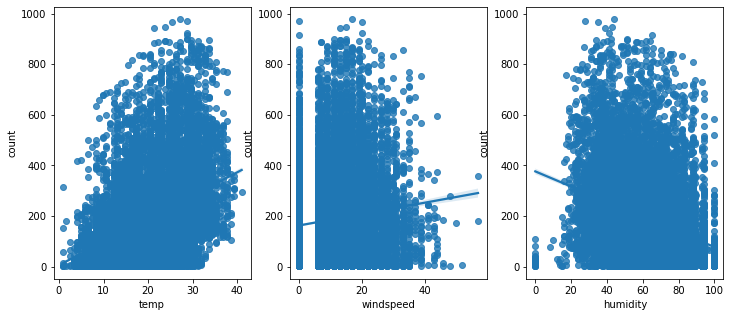

In [40]:
# Display a scatterplot of count and [temp, windspeed, humidity]
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=train_df,ax=ax1)
sns.regplot(x="windspeed", y="count", data=train_df,ax=ax2)
sns.regplot(x="humidity", y="count", data=train_df,ax=ax3)

### Data Visualization

Data visualization was performed to see the trend of each feature point

- The number of rentals varies from month to month, and January to March is relatively small.
- By season, spring is relatively rare.
- Hourly rental trends do not change with the seasons.
- You can see that the trends in the number of rentals by hour are completely different on weekdays and weekends.
- Comparing new registrations and existing registrations, the number of rentals for new registrations is relatively low, and the trends over time are different.
- Looking at the year-to-year comparison, we can see that the number of rentals in 2011 is relatively lower, but the hourly trend is almost the same.

The following is what I found by displaying the histogram of count, registered, and casual
- When I displayed the histogram of the number of rentals, I found that there was a bias. Machine learning is more accurate when the target variable has a normal distribution. Therefore, by removing the outliers and taking the logarithm, the distribution can be approximated to a normal distribution.
- The graph to the right of the histogram shows a normal distribution as the blue plot approaches a straight line.
- We found that registered and casual are also biased, so we can approach the normal distribution by taking the logarithm.
- Registered and casual have a minimum value of 0, so add 1 and take the logarithm to get closer to a normal distribution.

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of Year'),
 None]

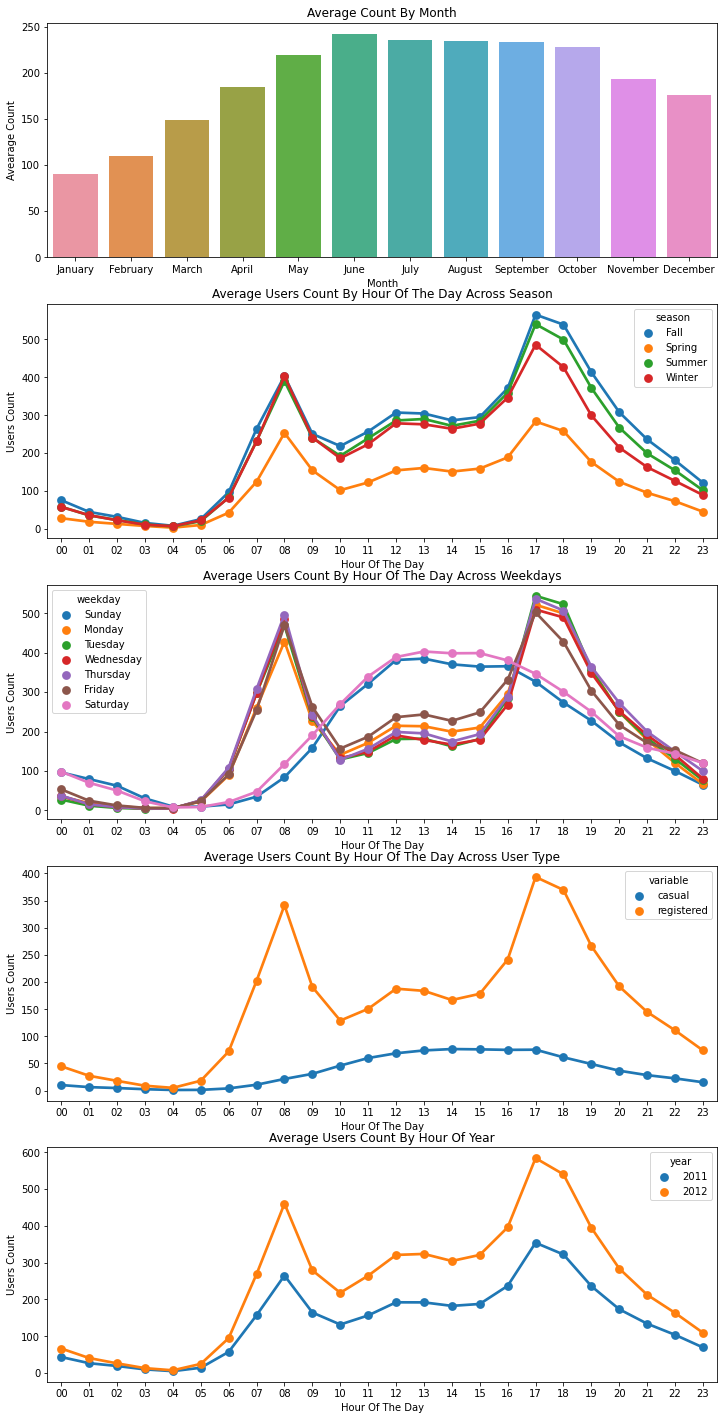

In [41]:
# Compare and visualize the number of rentals by month, season, time, day of the week, registration availability, and year
fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(12,25)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
yearOrder = ["2011", "2012"]

monthAggregated = pd.DataFrame(train_df.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sns.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(train_df.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(train_df.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(train_df[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

hourAggregated = pd.DataFrame(train_df.groupby(["hour","year"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["year"],hue_order=yearOrder, data=hourAggregated, join=True,ax=ax5)
ax5.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of Year",label='big')

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229765, 4.562423868087808, 0.9581176780909608))

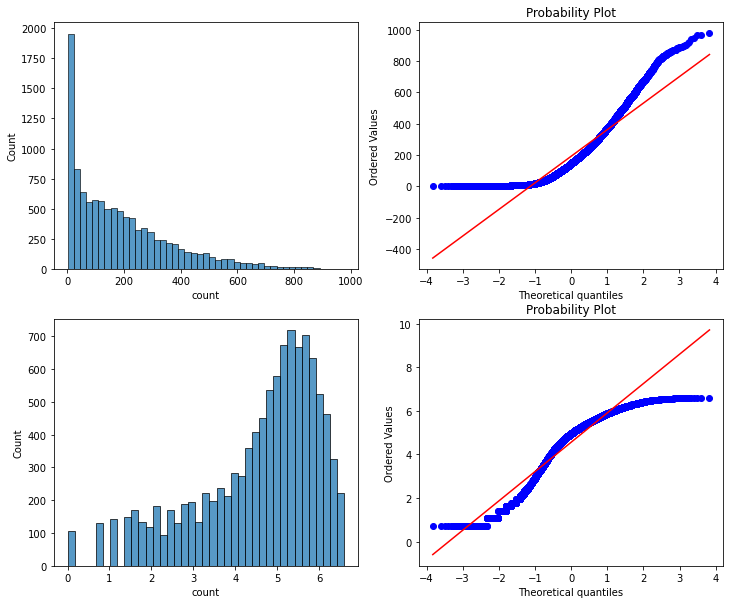

In [47]:
# Histogram display of counts
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sns.histplot(train_df["count"],ax=axes[0][0])
stats.probplot(train_df["count"], dist='norm', fit=True, plot=axes[0][1])
sns.histplot(np.log(train_df_without_outliers["count"]),ax=axes[1][0])
stats.probplot(np.log1p(train_df_without_outliers["count"]), dist='norm', fit=True, plot=axes[1][1])

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([  0,   0,   0, ..., 361, 362, 367])),
 (41.97830683719086, 36.021954804335834, 0.8399904742683882))

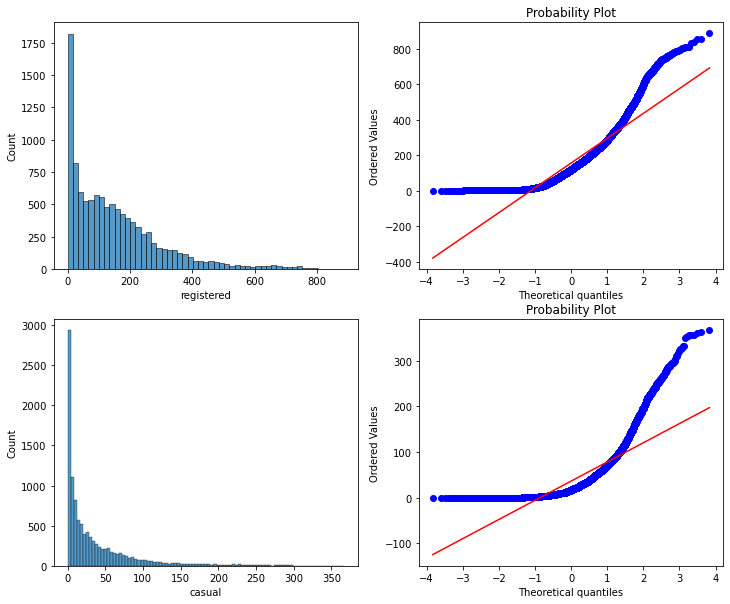

In [48]:
# Histogram display of registered and casual
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sns.histplot(train_df["registered"],ax=axes[0][0])
stats.probplot(train_df["registered"], dist='norm', fit=True, plot=axes[0][1])
sns.histplot(train_df["casual"],ax=axes[1][0])
stats.probplot(train_df["casual"], dist='norm', fit=True, plot=axes[1][1])

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.        , 0.        , 0.        , ..., 5.88053299, 5.89164421,
         5.90808294])),
 (1.462346241573083, 2.688527291125865, 0.9837698222231271))

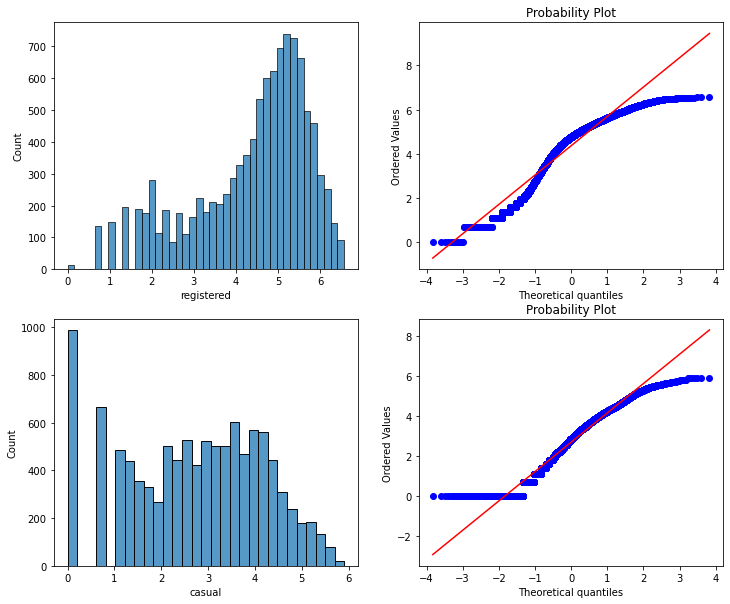

In [49]:
# Close to normal distribution by taking logarithm of registered and casual
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sns.histplot(np.log1p(train_df_without_outliers["registered"]),ax=axes[0][0])
stats.probplot(np.log1p(train_df_without_outliers["registered"]), dist='norm', fit=True, plot=axes[0][1])
sns.histplot(np.log1p(train_df_without_outliers["casual"]),ax=axes[1][0])
stats.probplot(np.log1p(train_df_without_outliers["casual"]), dist='norm', fit=True, plot=axes[1][1])

### fill those with 0 windspeed with predictions

In [52]:
# read dataset
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
print(train.shape)
print(test.shape)

(10886, 12)
(6493, 9)


In [53]:
# combine train and test
data = train.append(test)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)
print(data.shape)

(17379, 12)


In [54]:
# Feature engineering
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)
print(data.shape)

(17379, 17)


In [55]:
# fill in random forest with 0 windspeed

from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)
print(data.shape)

(17379, 17)


In [56]:
# Check if 0 is predicted by looking at windspeed stats
data['windspeed'].describe()

count    17379.000000
mean        14.072485
std          6.903250
min          6.003200
25%          8.998100
50%         12.998000
75%         19.001200
max         56.996900
Name: windspeed, dtype: float64

In [57]:
# change to categorical
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

In [58]:
# Split the dataset for training and testing
train = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
test = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = test["datetime"]
Y_train = train["count"]
Y_trainRegistered = train["registered"]
Y_trainCasual = train["casual"]

In [59]:
# Remove unnecessary feature points
dropFeatures = ['casual',"count","datetime","date","registered"]
train  = train.drop(dropFeatures,axis=1)
test  = test.drop(dropFeatures,axis=1)

In [60]:
# Function to calculate RMSLE, which is the evaluation index this time
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

### Predicting with a linear model

- linear regression
    - linear regression with simple least squares
    - RMSLE Value For Linear Regression: 0.977973952691398
- Ridge regression
    - Linear regression incorporating the concept of regularization to reduce overfitting
    - use the squared L2 norm as a regularization term
    - RMSLE Value For Ridge Regression: 0.9779739376235989
- Losso regression
    - Linear regression that incorporates the concept of regularization to reduce overfitting, similar to Ridge regression
    - use the L1 norm as a regularization term
    - RMSLE Value For Lasso Regression: 0.9781007117985129


In [61]:
# First, find by simple linear regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
Y_trainLog = np.log1p(Y_train)
lModel.fit(X = train,y = Y_trainLog)

# Make predictions
preds = lModel.predict(X= train)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(Y_trainLog),np.exp(preds),False))

RMSLE Value For Linear Regression:  0.9779708725911886


/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [62]:
# Then do Ridge Regression
ridge_m_ = Ridge()
# max_iter: maximum number of iterations, alpha: specify the strength of regularization (the larger the value, the simpler the model)
ridge_params_ = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
Y_trainLog = np.log1p(Y_train)
grid_ridge_m.fit( train, Y_trainLog )
preds = grid_ridge_m.predict(X= train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(Y_trainLog),np.exp(preds),False))

/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.

/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.

/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.

{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9779708575197326


/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [63]:
# Implementation of Lasso regression
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
Y_trainLog = np.log1p(Y_train)
grid_lasso_m.fit( train, Y_trainLog )
preds = grid_lasso_m.predict(X= train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(Y_trainLog),np.exp(preds),False))

/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.

/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.

/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.

/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


{'alpha': 0.005, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9781075412040262


### Prediction by ensemble learning

We implemented the following two algorithms using ensemble learning of decision trees:
- Random Forest
    - A typical example of an algorithm that uses a method called bagging even in ensemble learning
- gradient boosting
    - A method using gradient boosting, which is one of ensemble learning

In [64]:
# Random forest implementation
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
Y_trainLog = np.log1p(Y_train)
rfModel.fit(train,Y_trainLog)
preds = rfModel.predict(X= train)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(Y_trainLog),np.exp(preds),False))

RMSLE Value For Random Forest:  0.10313005262288447


In [65]:
# Implement gradient boosting
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01)
Y_trainLog = np.log1p(Y_train)
gbm.fit(train,Y_trainLog)
preds = gbm.predict(X= train)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(Y_trainLog),np.exp(preds),False))

RMSLE Value For Gradient Boost:  0.189440432354535


/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

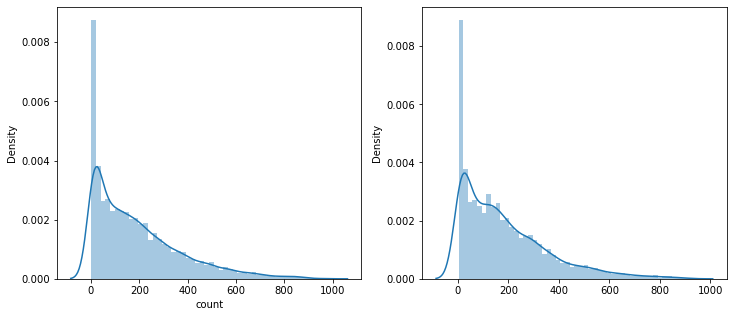

In [66]:
# make predictions on test data with random forest
predsTest = rfModel.predict(X= test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(Y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [67]:
# generate file for submission
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_predictions_rf_separate_without_fe.csv', index=False)

/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pratikshyaparajuli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

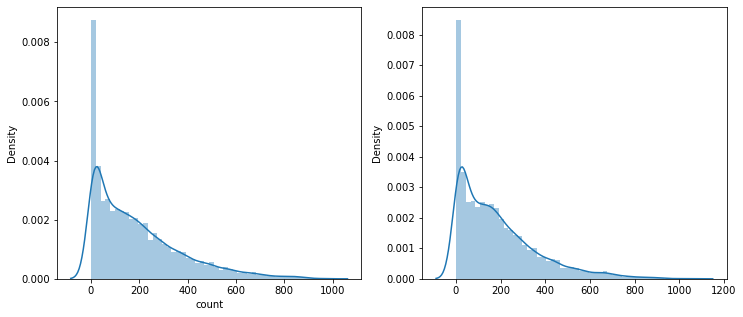

In [68]:
# make predictions on test data with random forest
predsTest = gbm.predict(X= test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(Y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [69]:
# generate file for submission
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_predictions_gbm_separate_without_fe.csv', index=False)

### submission

- submission: 0.4988 in random forest